## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'fourier'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")

Name the notebook:
blue_fourier_full_agriVision.ipynb


In [3]:
DATA_NAME='-'.join(path_list)

In [4]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = True
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/fourier/blue'

In [5]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [6]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 45000,
 3: 72000,
 4: 63000,
 5: 117000,
 6: 126000,
 7: 171000,
 8: 189000,
 9: 297000,
 10: 396000,
 11: 495000,
 12: 648000,
 13: 882000,
 14: 1134000,
 15: 1539000,
 16: 1953000,
 17: 2574000,
 18: 3456000,
 19: 4563000,
 20: 5967000,
 21: 8010000,
 22: 10395000,
 23: 13887000,
 24: 18297000,
 25: 24057000,
 26: 31968000,
 27: 42183000,
 28: 55764000,
 29: 73701000,
 30: 97326000,
 31: 108342000,
 32: 59634000,
 33: 21420000}

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

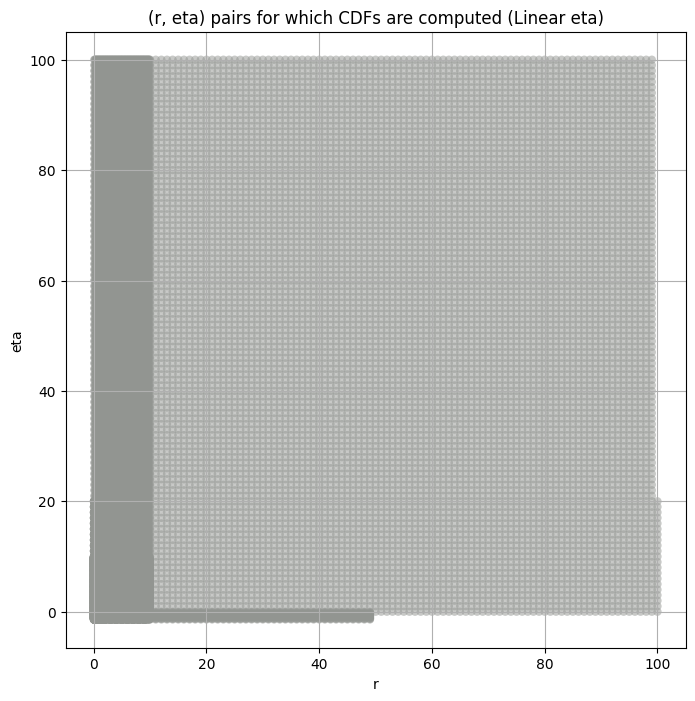

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


In [7]:
#warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if False or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [00:48<00:00, 2083.00it/s]


Band 5


100%|██████████| 100000/100000 [00:45<00:00, 2202.18it/s]


Band 8


100%|██████████| 100000/100000 [00:45<00:00, 2195.96it/s]


Band 11


100%|██████████| 100000/100000 [00:43<00:00, 2276.94it/s]


Band 14


100%|██████████| 100000/100000 [00:42<00:00, 2356.99it/s]


Band 17


100%|██████████| 100000/100000 [00:42<00:00, 2346.60it/s]


Band 20


100%|██████████| 100000/100000 [00:42<00:00, 2354.31it/s]


Band 23


100%|██████████| 100000/100000 [00:42<00:00, 2339.10it/s]


Band 26


100%|██████████| 100000/100000 [00:42<00:00, 2343.81it/s]


Band 29


100%|██████████| 100000/100000 [00:42<00:00, 2335.96it/s]


Band 32


100%|██████████| 100000/100000 [00:42<00:00, 2343.74it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,1292.946700,749.107670,2108.430700,421.84155,123.974430,696.23804,45000.0
5,662.654400,382.089750,1248.617800,628.03000,108.212240,1663.23950,117000.0
8,256.633900,133.792040,650.845600,1363.73070,99.365600,3639.23580,189000.0
11,121.961570,57.215298,390.192930,2698.31760,93.680930,4889.27800,495000.0
14,48.468010,23.179575,151.679550,2654.29520,86.305040,4711.62940,1134000.0
17,28.900380,10.379934,164.697750,12164.64200,72.317085,7907.98000,2574000.0
20,13.782273,5.692987,61.263600,5707.63040,75.890045,6510.24400,5967000.0
23,6.417106,2.075519,40.687180,14689.19500,66.177160,8234.63600,13887000.0
26,4.018234,0.584953,41.423286,32939.27000,74.598630,9373.83100,31968000.0


## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 10, 100]
SCALE_CAP = 1e5

In [11]:
EXCLUDE_CUTOFFS[:-0]

[]

In [12]:
augmented_obs_var_df = var_kurt_df[['obs_var']].copy()
augmented_obs_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))
    augmented_obs_var_df[f"exclude_{val}"] = temp_arr

augmented_obs_var_df

,obs_var,exclude_0,exclude_10,exclude_100
band,,,,
2,1292.946700,1292.946655,835.952332,375.158661
5,662.654400,662.654419,491.473816,266.718384
8,256.633900,256.633911,171.624725,95.406151
11,121.961570,121.961571,73.104111,41.040543
14,48.468010,48.468010,29.311842,16.936594
17,28.900380,28.900379,12.880033,7.842307
20,13.782273,13.782273,7.110548,4.270011
23,6.417106,6.417106,2.547090,1.588531
26,4.018234,4.018234,0.729856,0.442051


####
Band  2


100%|██████████| 55966/55966 [01:29<00:00, 627.52it/s]


Finding Minimum after computing 55966 CDFs
2 0 0.027114333574919297 1292.9467


100%|██████████| 55966/55966 [01:23<00:00, 667.88it/s]


Finding Minimum after computing 55966 CDFs
2 10 0.02064698087783079 835.95233


100%|██████████| 55966/55966 [01:31<00:00, 609.65it/s]


Finding Minimum after computing 55966 CDFs
2 100 0.006859730323207747 375.15866
Number of samples: 45000, Without approximation : 45000.0


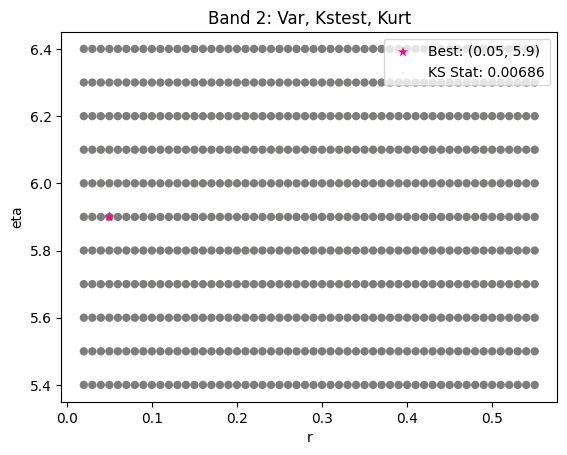

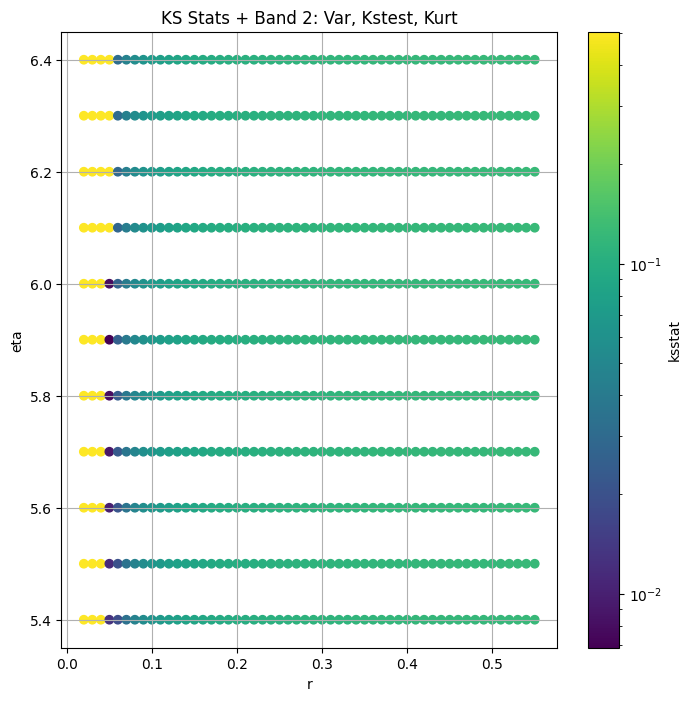

####
Band  5


100%|██████████| 55966/55966 [03:09<00:00, 295.86it/s]


Finding Minimum after computing 55966 CDFs
5 0 0.02700407959924092 662.6544


100%|██████████| 55966/55966 [03:08<00:00, 297.54it/s]


Finding Minimum after computing 55966 CDFs
5 10 0.022157001061599235 491.47382


100%|██████████| 55966/55966 [03:08<00:00, 297.54it/s]


Finding Minimum after computing 55966 CDFs
5 100 0.012005582566227135 266.71838
Number of samples: 100000, Without approximation : 117000.0


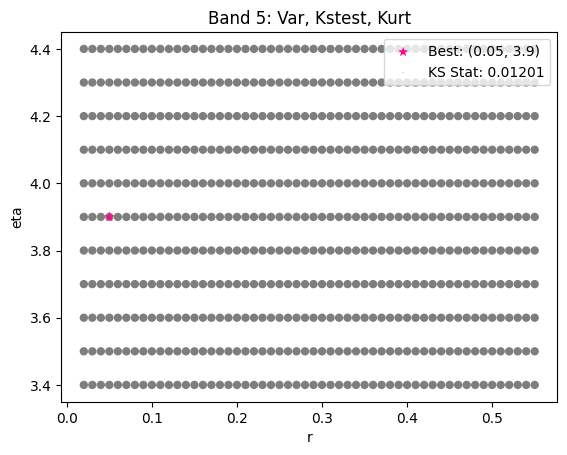

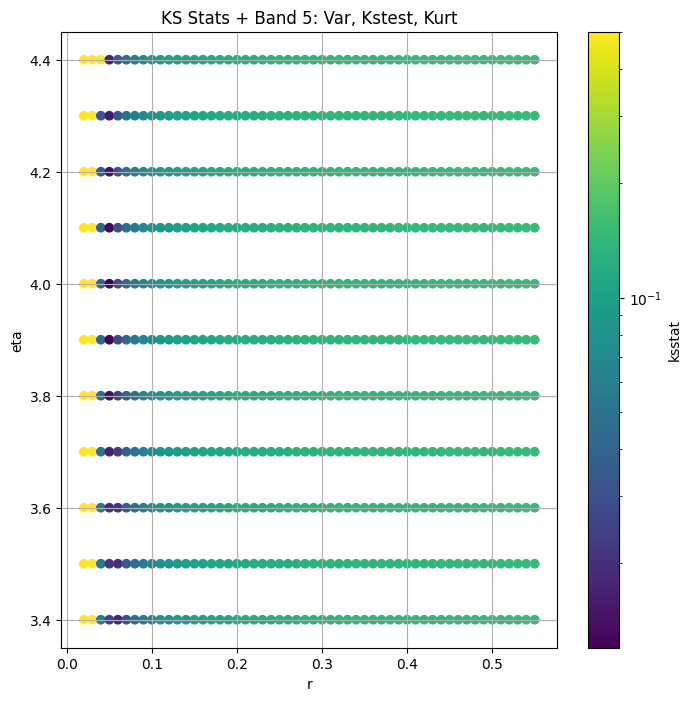

####
Band  8


100%|██████████| 55966/55966 [03:08<00:00, 297.35it/s]


Finding Minimum after computing 55966 CDFs
8 0 0.02978781609323089 256.6339


100%|██████████| 55966/55966 [03:07<00:00, 298.83it/s]


Finding Minimum after computing 55966 CDFs
8 10 0.02319722551493064 171.62473


100%|██████████| 55966/55966 [03:09<00:00, 295.77it/s]


Finding Minimum after computing 55966 CDFs
8 100 0.01170715406489753 95.40615
Number of samples: 100000, Without approximation : 189000.0


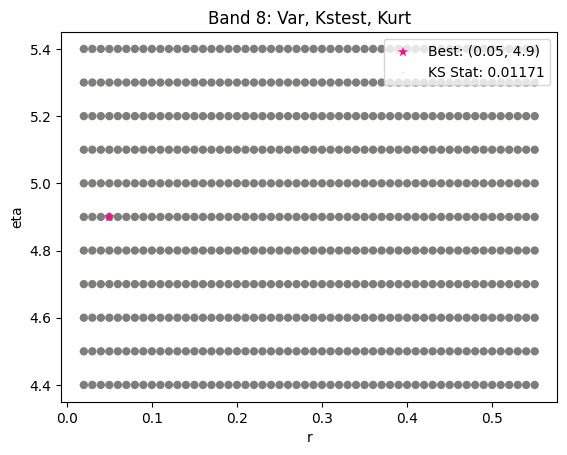

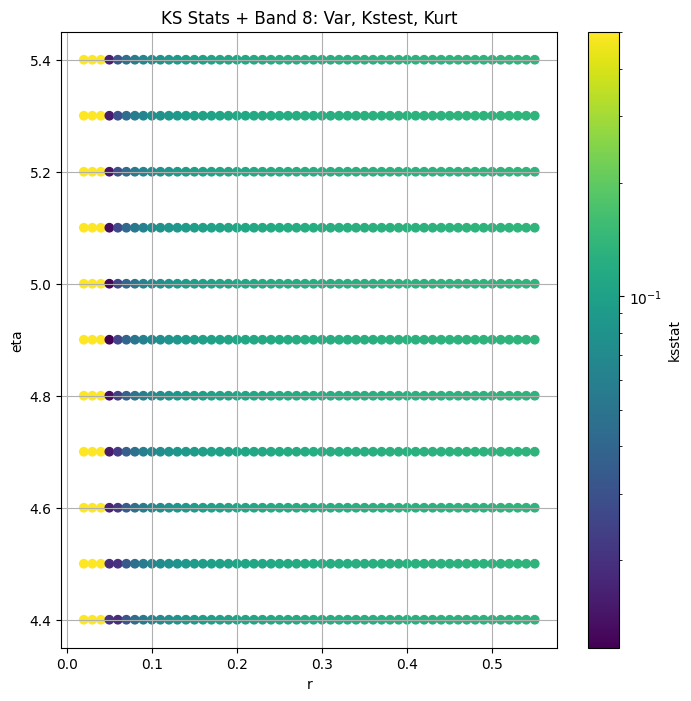

####
Band  11


100%|██████████| 55966/55966 [03:08<00:00, 297.59it/s]


Finding Minimum after computing 55966 CDFs
11 0 0.02829721169985651 121.96157


100%|██████████| 55966/55966 [03:14<00:00, 287.85it/s]


Finding Minimum after computing 55966 CDFs
11 10 0.019756976250210834 73.10411


100%|██████████| 55966/55966 [03:08<00:00, 297.66it/s]


Finding Minimum after computing 55966 CDFs
11 100 0.008023676724839737 41.040543
Number of samples: 100000, Without approximation : 495000.0


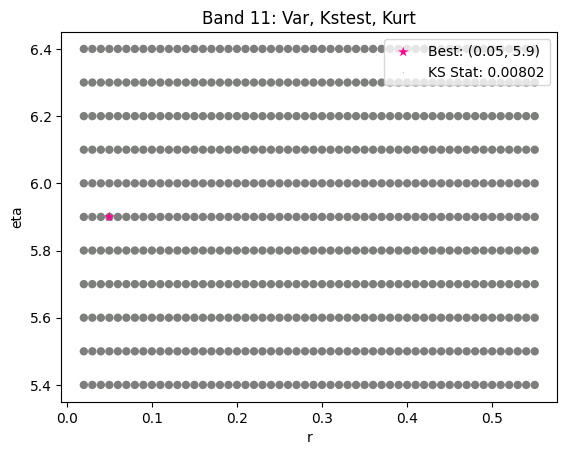

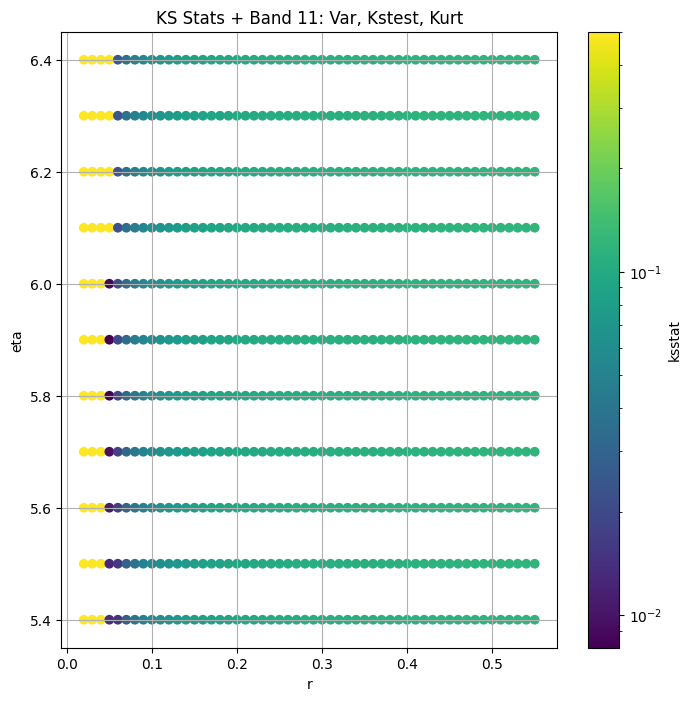

####
Band  14


100%|██████████| 55966/55966 [03:06<00:00, 300.71it/s]


Finding Minimum after computing 55966 CDFs
14 0 0.026263243714191198 48.46801


100%|██████████| 55966/55966 [03:05<00:00, 301.29it/s]


Finding Minimum after computing 55966 CDFs
14 10 0.017520832376996184 29.311842


100%|██████████| 55966/55966 [03:08<00:00, 296.73it/s]


Finding Minimum after computing 55966 CDFs
14 100 0.005015300462757111 16.936594
Number of samples: 100000, Without approximation : 1134000.0


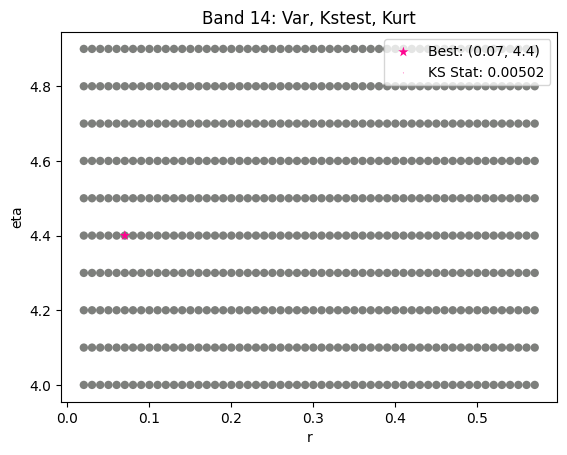

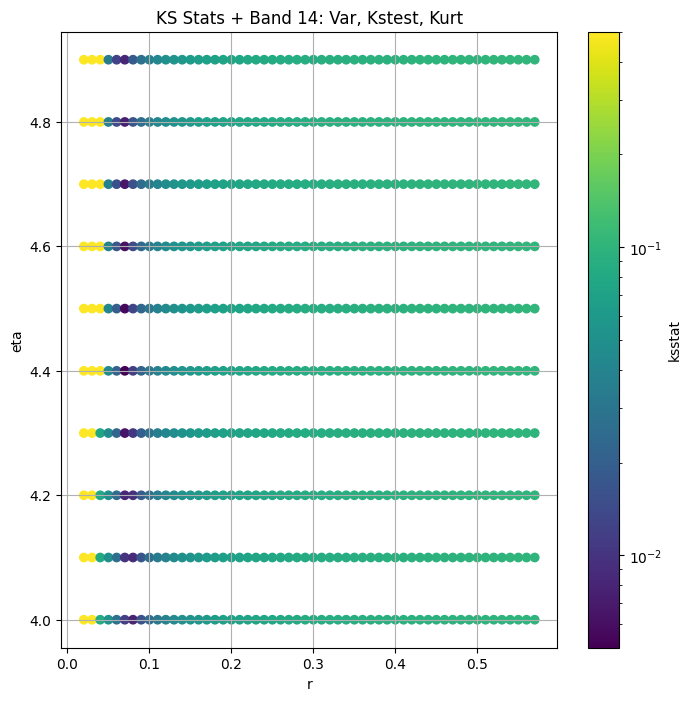

####
Band  17


100%|██████████| 55966/55966 [03:07<00:00, 298.52it/s]


Finding Minimum after computing 55966 CDFs
17 0 0.03016218286775174 28.90038


100%|██████████| 55966/55966 [03:06<00:00, 300.16it/s]


Finding Minimum after computing 55966 CDFs
17 10 0.014978843814752646 12.880033


100%|██████████| 55966/55966 [03:09<00:00, 295.41it/s]


Finding Minimum after computing 55966 CDFs
17 100 0.0031513678412855434 7.842307
Number of samples: 100000, Without approximation : 2574000.0


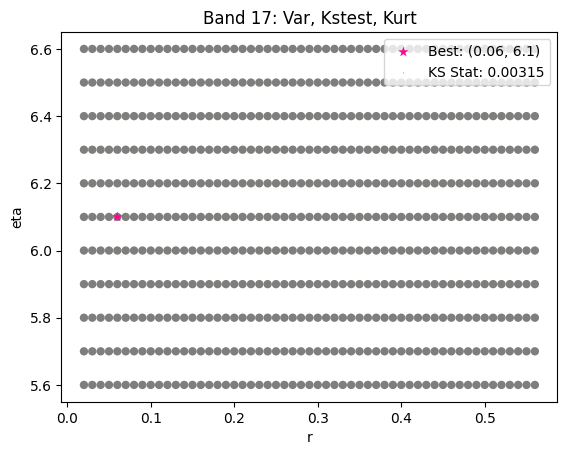

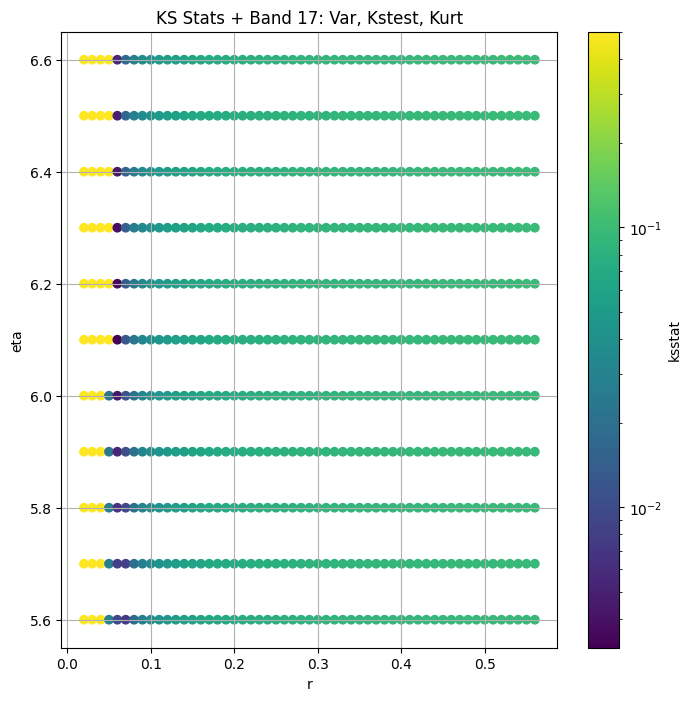

####
Band  20


100%|██████████| 55966/55966 [03:08<00:00, 296.24it/s]


Finding Minimum after computing 55966 CDFs
20 0 0.027850020757151706 13.782273


100%|██████████| 55966/55966 [03:16<00:00, 284.35it/s]


Finding Minimum after computing 55966 CDFs
20 10 0.015407796940282048 7.1105475


100%|██████████| 55966/55966 [03:05<00:00, 301.03it/s]


Finding Minimum after computing 55966 CDFs
20 100 0.004235698423045164 4.2700114
Number of samples: 100000, Without approximation : 5967000.0


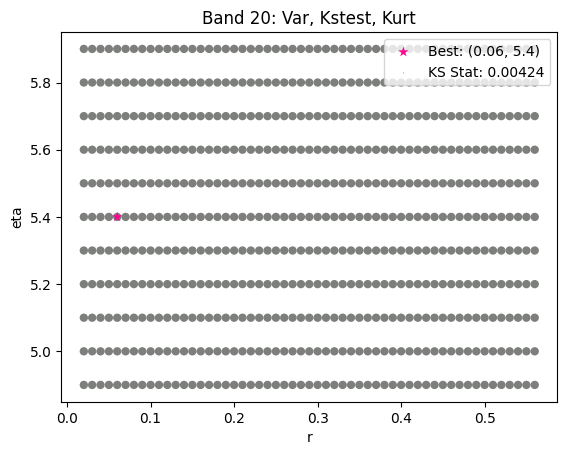

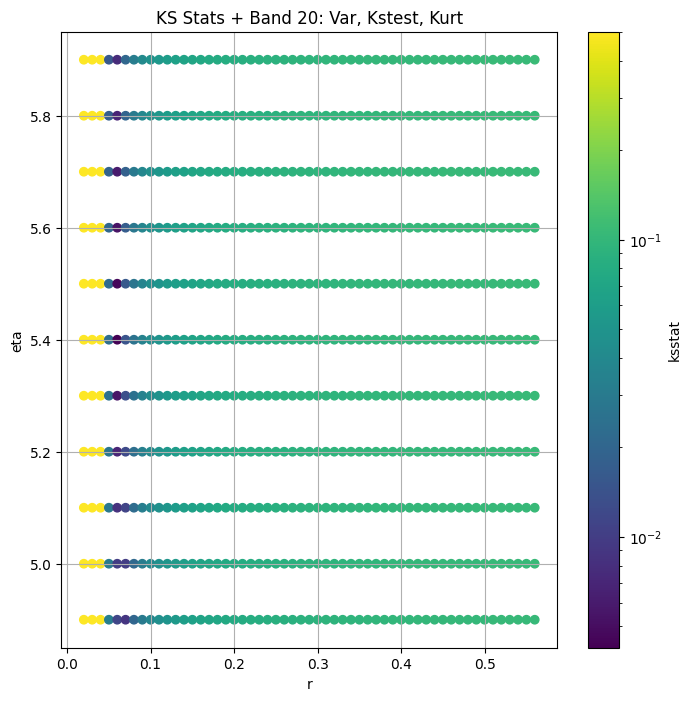

####
Band  23


100%|██████████| 55966/55966 [03:06<00:00, 299.71it/s]


Finding Minimum after computing 55966 CDFs
23 0 0.029415756173406443 6.417106


100%|██████████| 55966/55966 [03:05<00:00, 301.25it/s]


Finding Minimum after computing 55966 CDFs
23 10 0.013429474305401312 2.5470896


100%|██████████| 55966/55966 [03:05<00:00, 301.01it/s]


Finding Minimum after computing 55966 CDFs
23 100 0.004421758506158779 1.5885308
Number of samples: 100000, Without approximation : 13887000.0


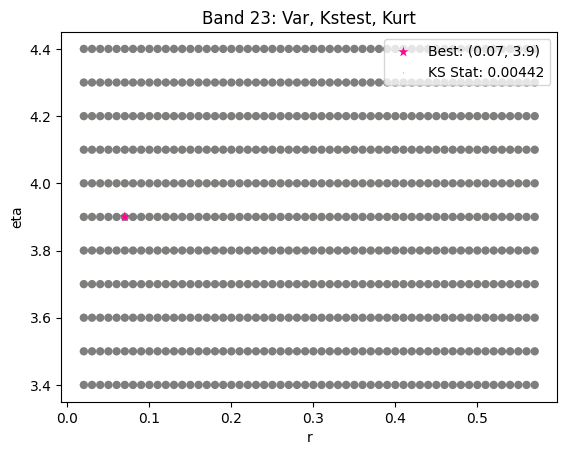

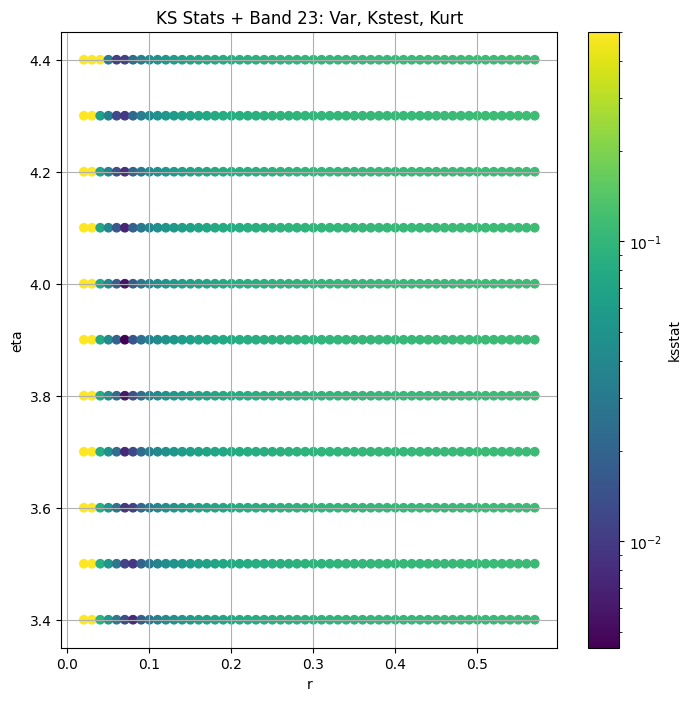

####
Band  26


100%|██████████| 55966/55966 [03:11<00:00, 292.60it/s]


Finding Minimum after computing 55966 CDFs
26 0 0.03646727536244543 4.0182343


100%|██████████| 55966/55966 [03:13<00:00, 288.99it/s]


Finding Minimum after computing 55966 CDFs
26 10 0.013443461135102752 0.7298556


100%|██████████| 55966/55966 [03:09<00:00, 294.65it/s]


Finding Minimum after computing 55966 CDFs
26 100 0.006109448061870637 0.44205058
Number of samples: 100000, Without approximation : 31968000.0


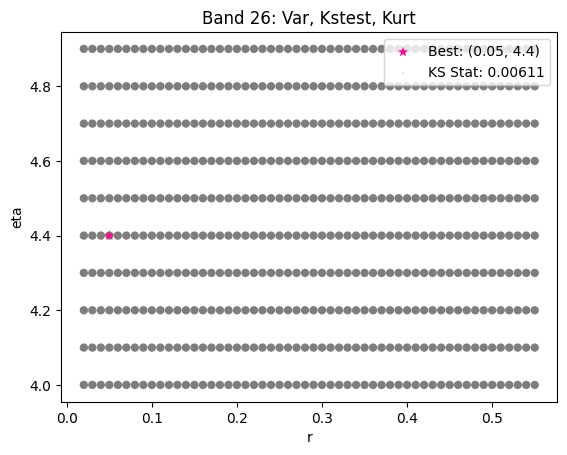

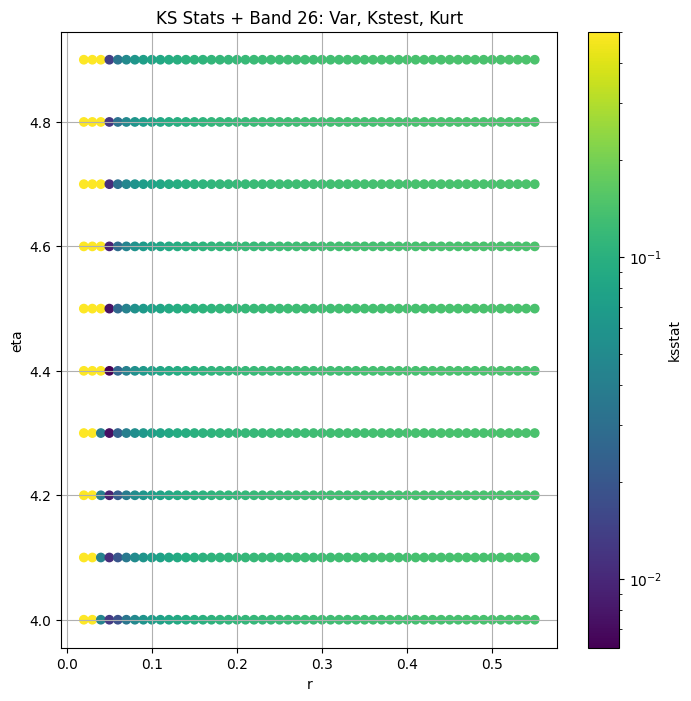

####
Band  29


100%|██████████| 55966/55966 [03:05<00:00, 300.93it/s]


Finding Minimum after computing 55966 CDFs
29 0 0.034432826880383405 0.41692203


100%|██████████| 55966/55966 [03:07<00:00, 298.88it/s]


Finding Minimum after computing 55966 CDFs
29 10 0.016166106865615343 0.09416052


100%|██████████| 55966/55966 [03:07<00:00, 298.07it/s]


Finding Minimum after computing 55966 CDFs
29 100 0.010221169834353228 0.055510044
Number of samples: 100000, Without approximation : 73701000.0


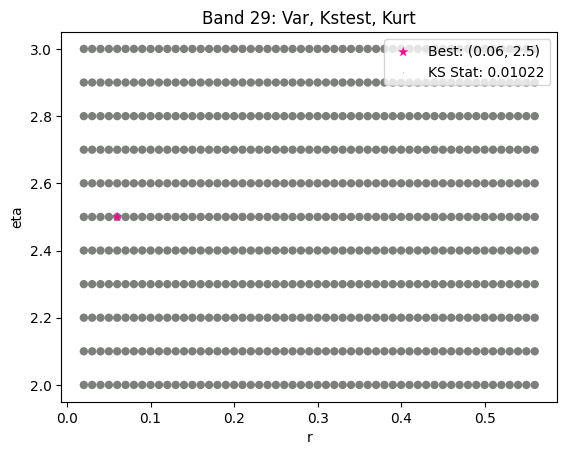

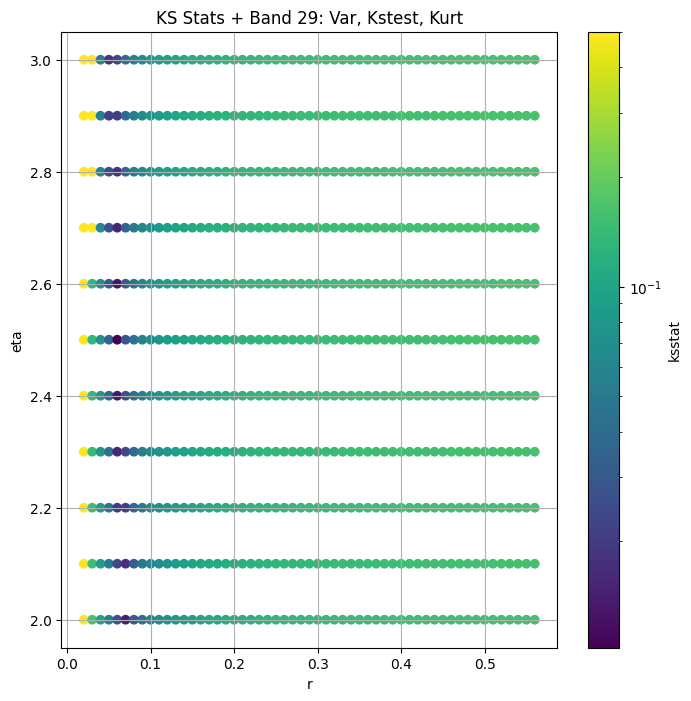

####
Band  32


100%|██████████| 55966/55966 [03:06<00:00, 299.49it/s]


Finding Minimum after computing 55966 CDFs
32 0 0.02754009760102516 0.013910068


100%|██████████| 55966/55966 [03:08<00:00, 296.79it/s]


Finding Minimum after computing 55966 CDFs
32 10 0.02281835212069394 0.009802431


100%|██████████| 55966/55966 [03:07<00:00, 298.19it/s]


Finding Minimum after computing 55966 CDFs
32 100 0.014934412535872965 0.0058673006
Number of samples: 100000, Without approximation : 59634000.0


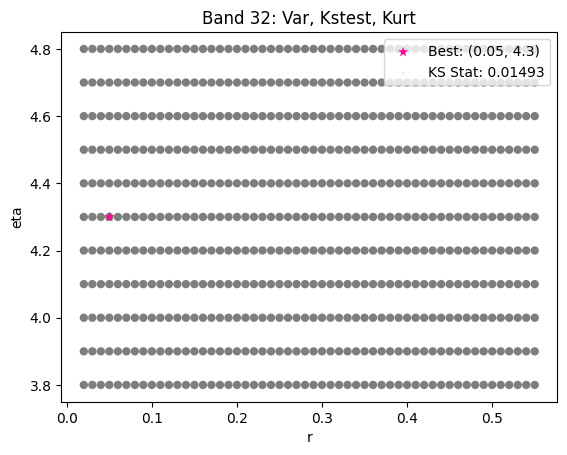

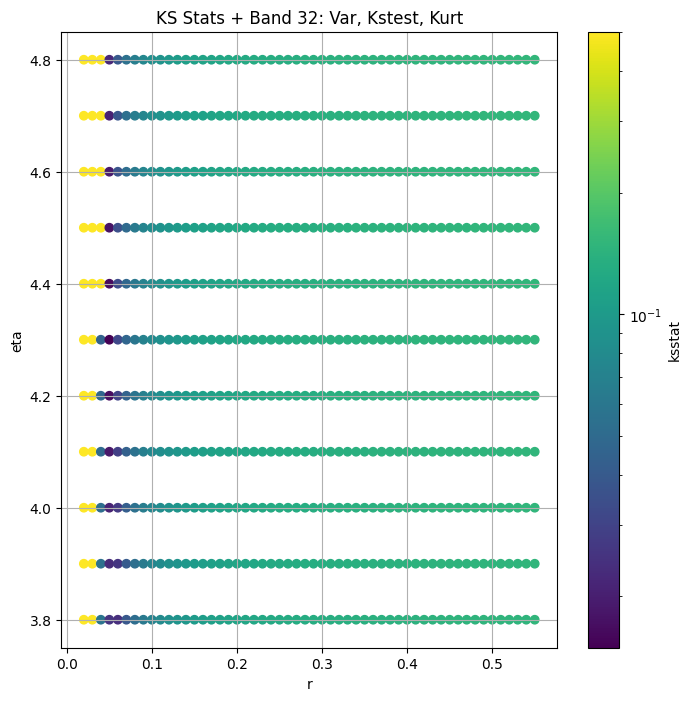

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,best_exclude_cutoff,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,
2,1292.946700,749.107670,2108.430700,421.84155,123.974430,696.23804,45000.0,0.006860,0.05,5.9,4.309551e-42,100.0,0.006398
5,662.654400,382.089750,1248.617800,628.03000,108.212240,1663.23950,117000.0,0.012006,0.05,3.9,1.085869e-39,100.0,0.003969
8,256.633900,133.792040,650.845600,1363.73070,99.365600,3639.23580,189000.0,0.011707,0.05,4.9,1.664073e-41,100.0,0.003123
11,121.961570,57.215298,390.192930,2698.31760,93.680930,4889.27800,495000.0,0.008024,0.05,5.9,4.714441e-43,100.0,0.001930
14,48.468010,23.179575,151.679550,2654.29520,86.305040,4711.62940,1134000.0,0.005015,0.07,4.4,1.793715e-27,100.0,0.001275
17,28.900380,10.379934,164.697750,12164.64200,72.317085,7907.98000,2574000.0,0.003151,0.06,6.1,2.632441e-35,100.0,0.000846
20,13.782273,5.692987,61.263600,5707.63040,75.890045,6510.24400,5967000.0,0.004236,0.06,5.4,6.516761e-35,100.0,0.000556
23,6.417106,2.075519,40.687180,14689.19500,66.177160,8234.63600,13887000.0,0.004422,0.07,3.9,5.427919e-28,100.0,0.000364
26,4.018234,0.584953,41.423286,32939.27000,74.598630,9373.83100,31968000.0,0.006109,0.05,4.4,3.500802e-43,100.0,0.000240


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for exclude_cutoff in EXCLUDE_CUTOFFS:
            if exclude_cutoff != 0:
                augmented_obs_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
            else:
                augmented_obs_var = np.var(group_data_map[group])
            group_cdf_df['scale'] = np.clip(augmented_obs_var / group_cdf_df['variance'], 0, SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
            group_cdf_df[f'ksstat_{exclude_cutoff}'] = ksstats
            print(group, exclude_cutoff, min_stat, augmented_obs_var)
            if min_stat < master_df.loc[group, 'kstest_stat_initial']:
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
        
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df

        temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
        rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']] + [temp_df[f'ksstat_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS]

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [14]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 645.39it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 292.06it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 289.16it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 296.61it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 294.77it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 274.96it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 293.51it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 294.67it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 293.38it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 294.60it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 287.50it/s]

Finding Minimum after computing 369 CDFs


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,best_exclude_cutoff,kstest_stat_cutoff_0.05,best_r_eta0,best_scale_eta0,kstest_stat_eta0
band,,,,,,,,,,,,,,,,
2,1292.946700,749.107670,2108.430700,421.84155,123.974430,696.23804,45000.0,0.006860,0.05,5.9,4.309551e-42,100.0,0.006398,5.8,0.009985,0.402344
5,662.654400,382.089750,1248.617800,628.03000,108.212240,1663.23950,117000.0,0.012006,0.05,3.9,1.085869e-39,100.0,0.003969,5.8,0.009985,0.421132
8,256.633900,133.792040,650.845600,1363.73070,99.365600,3639.23580,189000.0,0.011707,0.05,4.9,1.664073e-41,100.0,0.003123,5.8,0.009985,0.442364
11,121.961570,57.215298,390.192930,2698.31760,93.680930,4889.27800,495000.0,0.008024,0.05,5.9,4.714441e-43,100.0,0.001930,5.8,0.009985,0.455441
14,48.468010,23.179575,151.679550,2654.29520,86.305040,4711.62940,1134000.0,0.005015,0.07,4.4,1.793715e-27,100.0,0.001275,5.8,0.009985,0.466755
17,28.900380,10.379934,164.697750,12164.64200,72.317085,7907.98000,2574000.0,0.003151,0.06,6.1,2.632441e-35,100.0,0.000846,5.8,0.009985,0.474332
20,13.782273,5.692987,61.263600,5707.63040,75.890045,6510.24400,5967000.0,0.004236,0.06,5.4,6.516761e-35,100.0,0.000556,5.8,0.009985,0.478850
23,6.417106,2.075519,40.687180,14689.19500,66.177160,8234.63600,13887000.0,0.004422,0.07,3.9,5.427919e-28,100.0,0.000364,5.8,0.009985,0.484479
26,4.018234,0.584953,41.423286,32939.27000,74.598630,9373.83100,31968000.0,0.006109,0.05,4.4,3.500802e-43,100.0,0.000240,5.8,0.009985,0.489475


## Optimization

In [15]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:76: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * special.gamma(beta + 1/r) / special.gamma(beta)


Band 2
(0.042, 5.89), 50 of 420
(0.044, 5.99), 100 of 420
(0.047, 5.89), 150 of 420
(0.049, 5.99), 200 of 420
(0.052, 5.89), 250 of 420
(0.054, 5.99), 300 of 420
(0.057, 5.89), 350 of 420
(0.059, 5.99), 400 of 420


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

Finding Minimum after computing 420 CDFs
Iter 1 band 2 best parameters: ((0.049, 5.8), 0.10017688461079782)


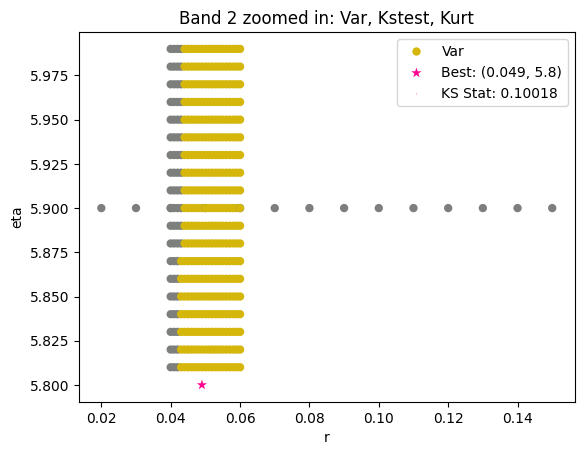

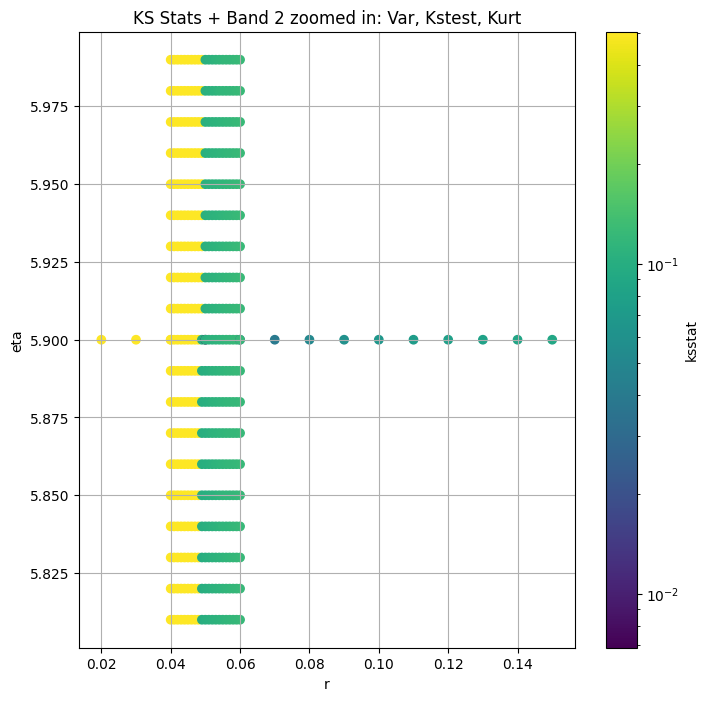

Band 5
(0.042, 3.87), 50 of 441
(0.044, 3.95), 100 of 441
(0.047, 3.82), 150 of 441
(0.049, 3.9), 200 of 441


AssertionError: KS test failed

In [16]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales=temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=kstest_stat)
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df

In [ ]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))